# CPGE/LPGE Data Analysis

* How analyse the current density
* The analysis is general and applies to any time series data

The DMD code outputs current density ($ j_x, j_y, j_x $) as a function time to text files `jx_elec_tot.out`, `jy_elec_tot.out`, and `jz_elec_tot.out`. The first column is time in atomic units, the second colulmn is $j_x$, third column is $j_x$ due to contributions from the diagonal elements of the density matrix, while the fourth column is $j_x$ due to contributions from the off-diagonal elements of the density matrix. The following python script reads current density time series data for plotting and analysis. Since we are interested in the constant (DC or zero-frequency) component of the current, we can perform the fast fourier transform (FFT) to obtain the frequency domain data. The FFT is sensitive to truncation errors so we also apply windows to make the time domain data smoothly go to zero. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import scipy.signal.windows as sgl
from scipy.optimize import curve_fit
import glob



fs  = 41.341373335
sec = 4.1341373335E+16
Hatree_to_eV = 27.2114
t_tot = 20.0

# funciton which performs FFT, 
# shifts frequency bins to only plot positive frequencies, 
# changes bins to physical units (eV), applies window to time domain data, 
# and returns a normalized FFT

def fft_of_j(j_t, cutoff):
    dt = j_t[1,0] - j_t[0,0]
    N_jt = j_t[cutoff:,1].shape[0]
    freq_bins = np.fft.fftfreq(N_jt, dt)*(2.0*np.pi*Hatree_to_eV)
    shifted_freq_bins = freq_bins[:len(freq_bins)//2]
    
    window = sgl.flattop(N_jt, sym=False)
    win_jt = window*j_t[cutoff:,1]
    
    fft = np.fft.fft(win_jt)
    shifted_fft = fft[:N_jt//2]
    return shifted_freq_bins, (1/N_jt)*(shifted_fft)

In [3]:
# read current density data from files 
jx_Ex_scat = np.loadtxt('jx_Ex_scat.out')

#jy_Ex_scat = np.loadtxt('jy_Ex_scat.out')
#jz_Ex_scat = np.loadtxt('jz_Ex_scat.out')

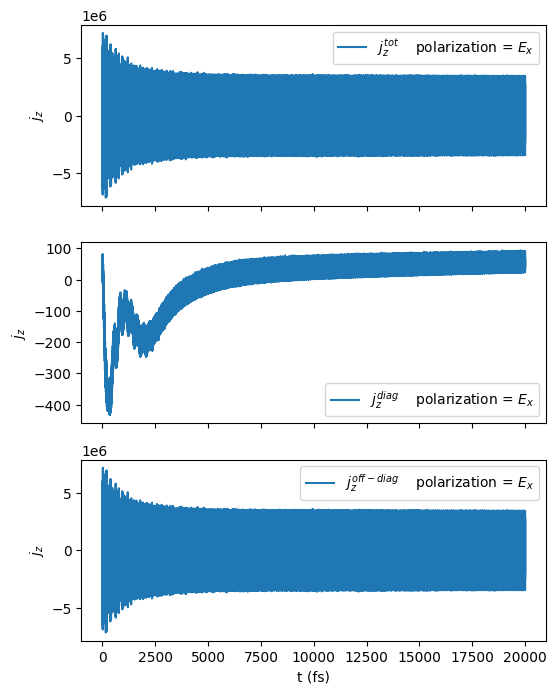

In [5]:
# plot different contributions

fig1, ax1 = plt.subplots(3,1, figsize=(6,8),sharex=True)

ax1[0].plot(jx_Ex_scat[:,0]/fs, jx_Ex_scat[:,1], label='$j_z^{tot}$    polarization = $E_x$')
ax1[0].set_ylabel('$j_z$')
ax1[0].legend()

ax1[1].plot(jx_Ex_scat[:,0]/fs, jx_Ex_scat[:,2], label=r'$j_z^{diag}$    polarization = $E_x$')
ax1[1].set_ylabel('$j_z$')
ax1[1].legend(loc='lower right')

ax1[2].plot(jx_Ex_scat[:,0]/fs, jx_Ex_scat[:,3], label=r'$j_z^{off-diag}$    polarization = $E_x$')
ax1[2].set_ylabel('$j_z$')
ax1[2].set_xlabel('t (fs)')
ax1[2].legend()

# save the graph to a file
fig1.savefig('jz-noscat-contrib.pdf')

jw_tot =  10.240466517602364
jw_d =  10.10474753023021
jw_od =  0.1357189873565106
j_d + j_od =  10.24046651758672


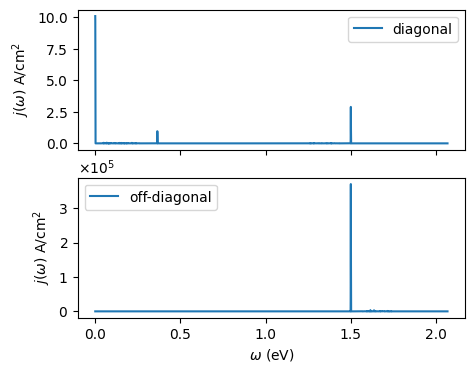

In [9]:
# FFT of different contributions

# as it is clear from the above graphs that there a transient at 
# at the start of dynamics. The transient can be removed by choosing 
# appropriate cutoff below

cutoff = 7000

f_tot, jw_tot = fft_of_j(jx_Ex_scat[:,0:2:1], cutoff)


f_d, jw_d = fft_of_j(jx_Ex_scat[:,0:3:2], cutoff)


f_od, jw_od = fft_of_j(jx_Ex_scat[:,0:4:3], cutoff)

print('jw_tot = ', abs(jw_tot[0]))
print('jw_d = ', abs(jw_d[0]))
print('jw_od = ', abs(jw_od[0]))
print('j_d + j_od = ', abs(jw_d[0] + jw_od[0]))


# Plot the FFT spectrum 

fig2, ax2 = plt.subplots(2,1,figsize=(5,4), sharex=True)

ax2[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2[1].yaxis.major.formatter._useMathText = True

ax2[0].plot(f_tot, abs(jw_d), label='diagonal')
ax2[0].set_ylabel('$j(\omega)$ A/cm$^2$')
ax2[0].legend()

ax2[1].plot(f_tot, abs(jw_od), label='off-diagonal')
ax2[1].set_ylabel('$j(\omega)$ A/cm$^2$')
ax2[1].set_xlabel('$\omega$ (eV)')
ax2[1].legend()

fig2.savefig('jz-noscat-contrib-fft.pdf')
